In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from datetime import datetime 


In [6]:

audio_file='UrbanSound8K/17973-2-0-32.wav'

librosa_ses_verisi, librosa_ornek_orani = librosa.load(audio_file)

In [7]:

print(librosa_ses_verisi)

[ 0.05885865  0.04666983 -0.02129572 ... -0.00733924  0.03293662
  0.09118845]


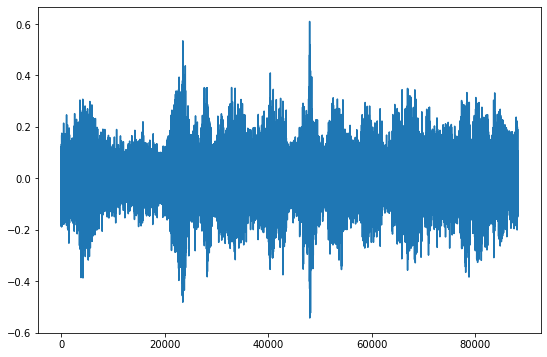

In [8]:

plt.figure(figsize=(9, 6))
plt.plot(librosa_ses_verisi)
plt.show()

In [10]:

from scipy.io import wavfile as wav
wave_ornek_orani, wave_ses_verisi = wav.read(audio_file)

In [11]:
wave_ses_verisi

array([[2189, 3314],
       [1592, 2598],
       [ 848, 1712],
       ...,
       [1326, 2602],
       [1915, 3542],
       [2542, 4449]], dtype=int16)

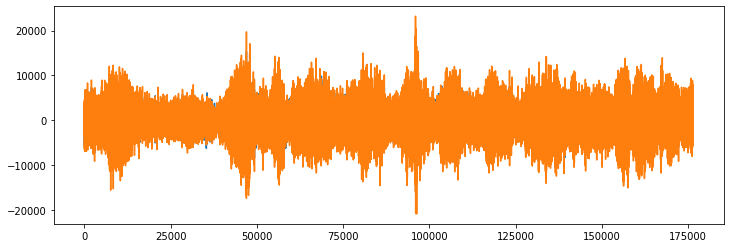

In [12]:
 
plt.figure(figsize=(12, 4))
plt.plot(wave_ses_verisi)
plt.show()

# FEATURE EXTRACTİON

In [13]:
mfccs = librosa.feature.mfcc(y=librosa_ses_verisi, sr=librosa_ornek_orani, n_mfcc=40)   
print(mfccs.shape)

(40, 173)


In [14]:
mfccs # dijital degerler

array([[-166.35619  , -151.73068  , -172.7387   , ..., -192.53252  ,
        -179.18051  , -179.66473  ],
       [  76.097015 ,   93.718475 ,  109.31448  , ...,  107.665855 ,
          87.36983  ,   67.36775  ],
       [-107.923645 , -119.106995 , -128.75359  , ..., -112.7724   ,
         -98.07146  ,  -85.822334 ],
       ...,
       [  -9.579795 ,   -8.808971 ,  -14.132212 , ...,   -6.5950513,
          -2.0341425,   -5.6390877],
       [   4.842807 ,    3.4938517,    5.1923413, ...,   -4.643508 ,
         -11.915147 ,  -17.247835 ],
       [   5.123097 ,    7.6599665,    7.043157 , ...,   -2.6938539,
          -6.4712753,   -7.279358 ]], dtype=float32)

In [15]:
audio_dataset='UrbanSound8K/audio/'
metadata=pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [16]:
def features_extractor(filename):
    ses, ornek_orani = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=ses, sr=ornek_orani, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

# dosyalarin hepsine feature extraction uygulamamiz lazim

In [17]:

extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [05:24, 11.45it/s]C:\Users\kubra\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8325it [12:20, 16.16it/s]C:\Users\kubra\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\kubra\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [12:52, 11.31it/s]


In [18]:

extracted_features_df = pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-218.18938, 71.38549, -131.49442, -52.25892, ...",dog_bark
1,"[-425.05234, 110.67095, -54.192833, 62.045414,...",children_playing
2,"[-459.82623, 122.82864, -47.908062, 53.302677,...",children_playing
3,"[-414.82184, 102.94826, -36.65685, 54.170742, ...",children_playing
4,"[-447.60776, 115.08627, -53.74607, 61.55309, 1...",children_playing


In [19]:
# Veri kümesini dependent ve independent olarak ayiralim
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [20]:
X.shape

(8732, 40)

In [21]:
X

array([[-218.18938   ,   71.38549   , -131.49442   , ...,   -1.5696381 ,
          -0.75472176,    0.5339845 ],
       [-425.05234   ,  110.67095   ,  -54.192833  , ...,    0.63086635,
          -0.6702725 ,    0.5963404 ],
       [-459.82623   ,  122.82864   ,  -47.908062  , ...,    2.194272  ,
           1.5538616 ,   -0.7991638 ],
       ...,
       [-304.84702   ,  112.69567   ,  -47.21992   , ...,   -3.0244386 ,
           2.6847007 ,    7.674591  ],
       [-345.06885   ,  126.78658   ,  -56.18254   , ...,   -7.8130603 ,
          -1.766159  ,    5.8158836 ],
       [-316.331     ,   95.86536   ,  -38.176315  , ...,    0.609448  ,
         -11.483956  ,   -5.9417233 ]], dtype=float32)

In [22]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [23]:
y.shape

(8732,)

In [24]:
# one-hot encoding

# 1 0 0 0 0 0 0 0 0 0 => air_conditioner
# 0 1 0 0 0 0 0 0 0 0 => car_horn
# 0 0 1 0 0 0 0 0 0 0 => children_playing
# 0 0 0 1 0 0 0 0 0 0 => dog_bark
# ...
# 0 0 0 0 0 0 0 0 0 1 => street_music

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [25]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
y[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [27]:

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [28]:

X_train

array([[-1.3211458e+02,  1.1391494e+02, -2.3927406e+01, ...,
         3.3260243e+00, -1.4790288e+00,  2.8912868e+00],
       [-1.4296137e+01,  9.1951004e+01, -8.6025953e+00, ...,
        -3.3708370e+00, -5.2008629e+00, -1.5975085e+00],
       [-4.9827820e+01,  1.8449375e-01, -2.0364500e+01, ...,
         2.0259936e+00, -8.3159256e-01,  2.7930872e+00],
       ...,
       [-4.2723694e+02,  9.2938095e+01,  2.8287885e+00, ...,
         8.1411362e-01,  6.6066742e-01,  7.8365982e-01],
       [-1.4640692e+02,  1.3716916e+02, -3.4362492e+01, ...,
         1.3839476e+00, -1.9667517e+00, -8.8792092e-01],
       [-4.2171307e+02,  2.1160454e+02,  2.5852380e+00, ...,
        -5.1338639e+00, -3.6135261e+00, -1.3413876e+00]], dtype=float32)

In [29]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
X_train.shape

(6985, 40)

In [31]:
X_test.shape

(1747, 40)

In [32]:
y_train.shape

(6985, 10)

In [33]:
y_test.shape

(1747, 10)

# CNN

In [34]:

num_labels = 10

In [35]:


model=Sequential()

model.add(Dense(125,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(125))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 125)               5125      
                                                                 
 activation (Activation)     (None, 125)               0         
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               31500     
                                                                 
 activation_1 (Activation)   (None, 250)               0         
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 125)               3

In [37]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [38]:

epochscount = 300
num_batch_size = 32

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=epochscount, validation_data=(X_test, y_test), verbose=1)


Epoch 1/300
219/219 [==============================] - 4s 5ms/step - loss: 10.2821 - accuracy: 0.1244 - val_loss: 2.2900 - val_accuracy: 0.1128
Epoch 2/300
219/219 [==============================] - 1s 3ms/step - loss: 2.4413 - accuracy: 0.1115 - val_loss: 2.2786 - val_accuracy: 0.1156
Epoch 3/300
219/219 [==============================] - 1s 4ms/step - loss: 2.3089 - accuracy: 0.1223 - val_loss: 2.2560 - val_accuracy: 0.1265
Epoch 4/300
219/219 [==============================] - 1s 4ms/step - loss: 2.2616 - accuracy: 0.1363 - val_loss: 2.2322 - val_accuracy: 0.1414
Epoch 5/300
219/219 [==============================] - 1s 3ms/step - loss: 2.2501 - accuracy: 0.1456 - val_loss: 2.1758 - val_accuracy: 0.1757
Epoch 6/300
219/219 [==============================] - 1s 4ms/step - loss: 2.2003 - accuracy: 0.1684 - val_loss: 2.1309 - val_accuracy: 0.1849
Epoch 7/300
219/219 [==============================] - 1s 4ms/step - loss: 2.1524 - accuracy: 0.1895 - val_loss: 2.0865 - val_accuracy: 0.198

Epoch 58/300
219/219 [==============================] - 1s 3ms/step - loss: 0.9697 - accuracy: 0.6800 - val_loss: 0.7913 - val_accuracy: 0.7527
Epoch 59/300
219/219 [==============================] - 1s 4ms/step - loss: 0.9566 - accuracy: 0.6795 - val_loss: 0.7587 - val_accuracy: 0.7624
Epoch 60/300
219/219 [==============================] - 1s 4ms/step - loss: 0.9602 - accuracy: 0.6754 - val_loss: 0.7704 - val_accuracy: 0.7579
Epoch 61/300
219/219 [==============================] - 1s 3ms/step - loss: 0.9354 - accuracy: 0.6888 - val_loss: 0.7455 - val_accuracy: 0.7762
Epoch 62/300
219/219 [==============================] - 1s 3ms/step - loss: 0.9440 - accuracy: 0.6826 - val_loss: 0.7588 - val_accuracy: 0.7659
Epoch 63/300
219/219 [==============================] - 1s 4ms/step - loss: 0.9419 - accuracy: 0.6931 - val_loss: 0.7526 - val_accuracy: 0.7647
Epoch 64/300
219/219 [==============================] - 1s 4ms/step - loss: 0.9467 - accuracy: 0.6863 - val_loss: 0.7803 - val_accuracy:

Epoch 115/300
219/219 [==============================] - 1s 3ms/step - loss: 0.8441 - accuracy: 0.7203 - val_loss: 0.6610 - val_accuracy: 0.7945
Epoch 116/300
219/219 [==============================] - 1s 4ms/step - loss: 0.8293 - accuracy: 0.7281 - val_loss: 0.6550 - val_accuracy: 0.8054
Epoch 117/300
219/219 [==============================] - 1s 3ms/step - loss: 0.8349 - accuracy: 0.7283 - val_loss: 0.6793 - val_accuracy: 0.7899
Epoch 118/300
219/219 [==============================] - 1s 3ms/step - loss: 0.8442 - accuracy: 0.7150 - val_loss: 0.6870 - val_accuracy: 0.7796
Epoch 119/300
219/219 [==============================] - 1s 3ms/step - loss: 0.8243 - accuracy: 0.7297 - val_loss: 0.6539 - val_accuracy: 0.7962
Epoch 120/300
219/219 [==============================] - 1s 3ms/step - loss: 0.8374 - accuracy: 0.7227 - val_loss: 0.6497 - val_accuracy: 0.7956
Epoch 121/300
219/219 [==============================] - 1s 3ms/step - loss: 0.8166 - accuracy: 0.7301 - val_loss: 0.6559 - val_ac

219/219 [==============================] - 1s 3ms/step - loss: 0.7318 - accuracy: 0.7555 - val_loss: 0.6143 - val_accuracy: 0.8060
Epoch 228/300
219/219 [==============================] - 1s 3ms/step - loss: 0.7638 - accuracy: 0.7535 - val_loss: 0.6184 - val_accuracy: 0.8082
Epoch 229/300
219/219 [==============================] - 1s 4ms/step - loss: 0.7466 - accuracy: 0.7598 - val_loss: 0.6500 - val_accuracy: 0.8077
Epoch 230/300
219/219 [==============================] - 1s 4ms/step - loss: 0.7560 - accuracy: 0.7483 - val_loss: 0.6225 - val_accuracy: 0.8100
Epoch 231/300
219/219 [==============================] - 1s 3ms/step - loss: 0.7679 - accuracy: 0.7513 - val_loss: 0.6198 - val_accuracy: 0.8214
Epoch 232/300
219/219 [==============================] - 1s 4ms/step - loss: 0.7524 - accuracy: 0.7503 - val_loss: 0.6331 - val_accuracy: 0.8134
Epoch 233/300
219/219 [==============================] - 1s 4ms/step - loss: 0.7637 - accuracy: 0.7420 - val_loss: 0.6304 - val_accuracy: 0.8065

In [39]:
validation_test_set_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(validation_test_set_accuracy[1])

0.8219805359840393


In [40]:
X_test[1]

array([-466.47327   ,    1.5016655 ,  -34.40004   ,   35.6894    ,
        -15.182924  ,  -18.883924  ,   -0.7577297 ,  -16.02822   ,
        -21.365473  ,    7.6201305 ,  -29.034496  ,  -19.153776  ,
         -2.6873193 ,   -8.493191  ,  -14.771136  ,   -7.028892  ,
         -7.1169443 ,    8.868939  ,   14.91199   ,   21.457466  ,
         21.327414  ,    0.88716304,  -18.810377  ,   -5.017963  ,
         -0.70585895,    2.9008534 ,   -6.7110267 ,  -16.649857  ,
         -9.8316965 ,   12.847431  ,    0.66192484,  -23.943693  ,
        -15.194154  ,    9.193658  ,   10.399716  ,   -0.59991807,
         -1.2594266 ,   17.706207  ,   13.831075  ,   -5.1632876 ],
      dtype=float32)

In [43]:
predict_x=model.predict(X_test) 

### Test 1 Polis siren sesi

In [67]:
filename="UrbanSound8K/PoliceSiren.wav"
ses_verisi, ornek_orani = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=ses_verisi, sr=ornek_orani, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [68]:
print(mfccs_scaled_features)

[-5.09955933e+02  5.81468315e+01 -2.67072601e+01 -1.73720398e+01
 -2.87463784e+00  1.19507093e+01  3.40505714e+01  2.47624207e+01
  4.62381172e+00  3.07009392e-03  4.95518780e+00  1.84918940e+00
 -1.07316532e+01 -1.17603445e+01 -9.50562572e+00 -1.46199570e+01
 -1.19073582e+01 -7.13640594e+00 -6.33557177e+00 -2.02259079e-01
  1.84976828e+00 -4.46638155e+00 -6.67025089e+00 -4.16968870e+00
 -8.34630370e-01  1.03797650e+00 -1.69586885e+00 -3.12392020e+00
  6.94756150e-01  4.18097210e+00  6.15199387e-01 -7.59931231e+00
 -7.34422064e+00 -1.64326704e+00 -1.62685502e+00 -1.00775409e+00
 -7.94724166e-01 -3.78943038e+00 -2.60853767e+00 -2.70201993e+00]


In [69]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)

In [70]:
mfccs_scaled_features.shape

(1, 40)

In [71]:
print(mfccs_scaled_features)

[[-5.09955933e+02  5.81468315e+01 -2.67072601e+01 -1.73720398e+01
  -2.87463784e+00  1.19507093e+01  3.40505714e+01  2.47624207e+01
   4.62381172e+00  3.07009392e-03  4.95518780e+00  1.84918940e+00
  -1.07316532e+01 -1.17603445e+01 -9.50562572e+00 -1.46199570e+01
  -1.19073582e+01 -7.13640594e+00 -6.33557177e+00 -2.02259079e-01
   1.84976828e+00 -4.46638155e+00 -6.67025089e+00 -4.16968870e+00
  -8.34630370e-01  1.03797650e+00 -1.69586885e+00 -3.12392020e+00
   6.94756150e-01  4.18097210e+00  6.15199387e-01 -7.59931231e+00
  -7.34422064e+00 -1.64326704e+00 -1.62685502e+00 -1.00775409e+00
  -7.94724166e-01 -3.78943038e+00 -2.60853767e+00 -2.70201993e+00]]


In [72]:
print(mfccs_scaled_features.shape)

(1, 40)


In [73]:
result_array = model.predict(mfccs_scaled_features)

In [74]:
result_array 

array([[2.1549167e-29, 8.9839363e-19, 4.1139964e-10, 4.4014574e-05,
        2.6759774e-17, 2.1303300e-15, 2.5540375e-11, 4.3372054e-29,
        9.9995601e-01, 4.0407638e-13]], dtype=float32)

In [75]:
result_classes = ["air_conditioner","car_horn","children_playing","dog_bark","drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

result = np.argmax(result_array[0])
print(result_classes[result]) 

siren


### Test 2 

In [76]:
filename="UrbanSound8K/101415-3-0-2.wav"
ses_verisi, ornek_orani = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=ses_verisi, sr=ornek_orani, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [77]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)

In [78]:
result_array = model.predict(mfccs_scaled_features)

In [79]:
result_array 

array([[3.2854962e-38, 1.3906838e-23, 7.3822826e-18, 1.0000000e+00,
        9.6344605e-23, 1.0364998e-32, 2.0149131e-09, 0.0000000e+00,
        9.2617727e-14, 1.5660862e-19]], dtype=float32)

In [80]:
result_classes = ["air_conditioner","car_horn","children_playing","dog_bark","drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

result = np.argmax(result_array[0])
print(result_classes[result]) 

dog_bark


### Test 3 

In [81]:
filename="UrbanSound8K/101415-3-0-2.wav"
ses_verisi, ornek_orani = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=ses_verisi, sr=ornek_orani, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [82]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)

In [83]:
result_array = model.predict(mfccs_scaled_features)

In [84]:
result_array 

array([[3.2854962e-38, 1.3906838e-23, 7.3822826e-18, 1.0000000e+00,
        9.6344605e-23, 1.0364998e-32, 2.0149131e-09, 0.0000000e+00,
        9.2617727e-14, 1.5660862e-19]], dtype=float32)

In [85]:
result_classes = ["air_conditioner","car_horn","children_playing","dog_bark","drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

result = np.argmax(result_array[0])
print(result_classes[result]) 

dog_bark
